In [1]:
import torch
import numpy as np
from torchvision import datasets
import torch.nn.functional as F

train_on_gpu = torch.cuda.is_available()

device = 'cuda' if train_on_gpu else 'cpu'

# **1. EDA, выбор метрики и аугментаций**

Произведем разведочный анализ для датасета Food101, который содержит 101 класс с различными видами блюд.

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.image as mpimg

import torch
import torch.nn as nn
import torch.optim as optim 

import torchvision
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils
from torchvision import transforms
from itertools import islice

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import linecache
import math

import warnings
warnings.filterwarnings("ignore")

In [3]:
num_of_classes = 101
photo_size = 256

In [87]:
train_dataset = datasets.Food101(root='./data', download=True, split='train')
test_dataset = datasets.Food101(root='./data', download=True, split='test')

In [88]:
len(train_dataset.classes)

101

Для того, чтобы графики распределения классов отображались корректно, вместо названий классов на графике будут показываться их id. Чтобы получить название класса, можно воспользоваться словарем id2label:

In [89]:
label2id = {label: id for id, label in enumerate(train_dataset.classes)}
id2label = {id: label for id, label in enumerate(train_dataset.classes)}

In [90]:
train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]
test_labels = [test_dataset[i][1] for i in range(len(test_dataset))]

In [56]:
df = pd.DataFrame({'train_labels': np.array(train_labels)})
df_test = pd.DataFrame({'test_labels': np.array(test_labels)})

Text(0, 0.5, 'Частота')

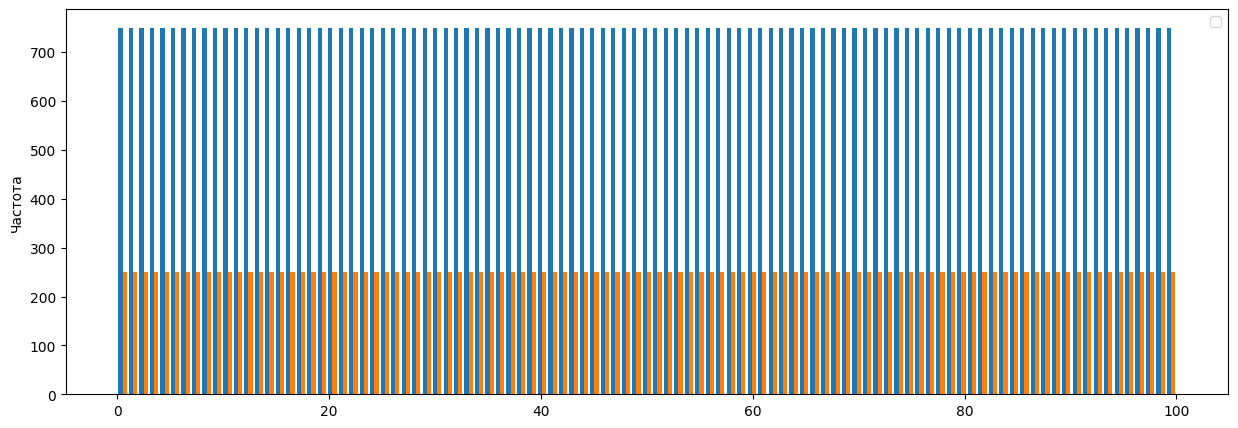

In [74]:
plt.figure(figsize=(15, 5))

plt.hist([df['train_labels'],
          df_test['test_labels']], bins=101)
plt.legend()
plt.ylabel('Частота')

Как нетрудно заметить, данные внутри сбалансированы по классам, поэтому в качестве метрики можно использовать **accuracy**.

Было решено следующие аугментации: для train перевод объекта PIL.Image в тензор, случайное аффинное преобразование и случайный кроп, приводящий фотографии к размеру 256x256, для test - перевод объекта PIL.Image в тензор и перевод фотографии к размеру 256x256.

In [91]:
train_transforms = transforms.Compose([
                                    transforms.ToTensor(),  
                                    transforms.RandomAffine(degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
                                    transforms.RandomResizedCrop((photo_size, photo_size), scale=(0.75, 1))])

test_transforms = transforms.Compose([transforms.ToTensor(), transforms.Resize((photo_size, photo_size))])

In [92]:
train_dataset = datasets.Food101(root='./data', download=True, split='train', transform=train_transforms)
test_dataset = datasets.Food101(root='./data', download=True, split='test', transform=test_transforms)

In [93]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# **2. Выбор архитектуры**

В качестве классификатора было решено использовать модели семейства EfficientNet, поскольку они превосходят по качеству более простые модели (например, модели семейств ResNet, DenseNet, Inception)

In [8]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=7c0a55cdefb4b451cff899d53d8f4fc9dce432a5628b1e901bea74f3a66c066d
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


# **2.1 Модель EfficientNet-B1 с CrossEntropyLoss**

In [13]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_name('efficientnet-b1')

In [19]:
for param in model.parameters():
    param.requires_grad = True

In [20]:
model._fc = nn.Linear(model._fc.in_features, num_of_classes)

In [21]:
model = model.to(device)

In [11]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch, arcface=False):
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    batch_idx = 0
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_criteria(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        batch_idx += 1

    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    target_all = []
    predicted_all = []
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_criteria(output, target).item()
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()
            target_all.extend(target.cpu().numpy())
            predicted_all.extend(predicted.cpu().numpy())

    avg_loss = test_loss/batch_count
    precision = round(precision_score(target_all, predicted_all, average='weighted'), 2)
    recall = round(recall_score(target_all, predicted_all, average='weighted'), 2)
    f1 = round(f1_score(target_all, predicted_all, average='weighted'), 2)
    accuracy = round((accuracy_score(target_all, predicted_all)*100),2)
    return avg_loss, accuracy, precision, recall, f1

In [46]:
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_criteria = nn.CrossEntropyLoss()

epoch_nums = []
training_loss = []
validation_loss = []
accuracy = []

epochs = 10
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss[0])
        accuracy.append(test_loss[1])
        print(f'Epoch accuracy: {accuracy[-1]}')

Epoch: 1


100%|██████████| 1184/1184 [12:59<00:00,  1.52it/s]


Training set: Average loss: 2.948919
Epoch accuracy: 32.53
Epoch: 2


100%|██████████| 1184/1184 [12:42<00:00,  1.55it/s]


Training set: Average loss: 2.608254
Epoch accuracy: 38.84
Epoch: 3


100%|██████████| 1184/1184 [13:14<00:00,  1.49it/s]


Training set: Average loss: 2.344420
Epoch accuracy: 40.65
Epoch: 4


100%|██████████| 1184/1184 [12:42<00:00,  1.55it/s]


Training set: Average loss: 2.139149
Epoch accuracy: 49.61
Epoch: 5


100%|██████████| 1184/1184 [12:45<00:00,  1.55it/s]


Training set: Average loss: 1.962312
Epoch accuracy: 52.03
Epoch: 6


100%|██████████| 1184/1184 [12:34<00:00,  1.57it/s]


Training set: Average loss: 1.817509
Epoch accuracy: 52.65
Epoch: 7


100%|██████████| 1184/1184 [12:38<00:00,  1.56it/s]


Training set: Average loss: 1.694640
Epoch accuracy: 55.03
Epoch: 8


100%|██████████| 1184/1184 [12:42<00:00,  1.55it/s]


Training set: Average loss: 1.583487
Epoch accuracy: 59.12
Epoch: 9


100%|██████████| 1184/1184 [12:47<00:00,  1.54it/s]


Training set: Average loss: 1.480812
Epoch accuracy: 60.98
Epoch: 10


100%|██████████| 1184/1184 [12:45<00:00,  1.55it/s]


Training set: Average loss: 1.390024
Epoch accuracy: 61.26


In [69]:
for epoch in range(11, epochs + 11):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss[0])
        accuracy.append(test_loss[1])
        print(f'Epoch accuracy: {accuracy[-1]}')

Epoch: 11


100%|██████████| 1184/1184 [12:59<00:00,  1.52it/s]


Training set: Average loss: 1.236076
Epoch accuracy: 65.37
Epoch: 12


100%|██████████| 1184/1184 [12:55<00:00,  1.53it/s]


Training set: Average loss: 1.156893
Epoch accuracy: 65.69
Epoch: 13


100%|██████████| 1184/1184 [13:08<00:00,  1.50it/s]


Training set: Average loss: 1.090610
Epoch accuracy: 65.36
Epoch: 14


100%|██████████| 1184/1184 [12:44<00:00,  1.55it/s]


Training set: Average loss: 1.022605
Epoch accuracy: 65.6
Epoch: 15


100%|██████████| 1184/1184 [12:39<00:00,  1.56it/s]


Training set: Average loss: 0.964911
Epoch accuracy: 67.12
Epoch: 16


100%|██████████| 1184/1184 [12:38<00:00,  1.56it/s]


Training set: Average loss: 0.900869
Epoch accuracy: 66.24
Epoch: 17


100%|██████████| 1184/1184 [12:44<00:00,  1.55it/s]


Training set: Average loss: 0.853493
Epoch accuracy: 67.27
Epoch: 18


100%|██████████| 1184/1184 [12:53<00:00,  1.53it/s]


Training set: Average loss: 0.799628
Epoch accuracy: 67.44
Epoch: 19


100%|██████████| 1184/1184 [12:57<00:00,  1.52it/s]


Training set: Average loss: 0.749910
Epoch accuracy: 66.53
Epoch: 20


100%|██████████| 1184/1184 [12:46<00:00,  1.54it/s]


Training set: Average loss: 0.701093
Epoch accuracy: 67.33


In [70]:
torch.save(model.state_dict(), 'efficientnet_20_epochs.pt')

In [71]:
from IPython.display import FileLink
FileLink(r'efficientnet_20_epochs.pt')

/kaggle/working/efficientnet_20_epochs.pt

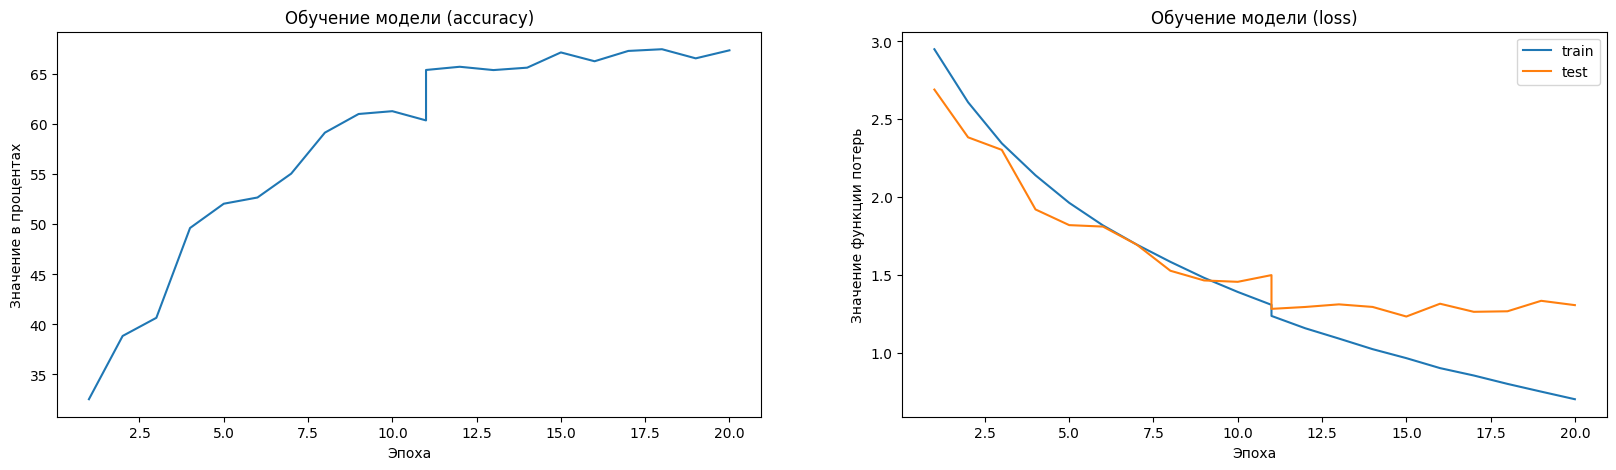

In [93]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(epoch_nums, accuracy)
plt.title('Обучение модели  (accuracy)')
plt.xlabel('Эпоха')
plt.ylabel('Значение в процентах')

plt.subplot(1, 2, 2)
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.title('Обучение модели (loss)')
plt.xlabel('Эпоха')
plt.ylabel('Значение функции потерь')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [96]:
print(f"EfficientNet-B1 accuracy: {round(test_loss[1] / 100, 2)}")
print(f"EfficientNet-B1 precision (weighted): {test_loss[2]}")
print(f"EfficientNet-B1 recall (weighted): {test_loss[3]}")
print(f"EfficientNet-B1 f1 (weighted): {test_loss[4]}")

EfficientNet-B1 accuracy: 0.67
EfficientNet-B1 precision (weighted): 0.69
EfficientNet-B1 recall (weighted): 0.67
EfficientNet-B1 f1 (weighted): 0.67


# **2.2 Модель EfficientNet-B2 с CrossEntropyLoss**

In [9]:
from efficientnet_pytorch import EfficientNet

model = EfficientNet.from_name('efficientnet-b2')
for param in model.parameters():
    param.requires_grad = True
model._fc = nn.Linear(model._fc.in_features, num_of_classes)
model = model.to(device)

In [15]:
# Create an instance of the model class and allocate it to the device
model = model.to(device)

# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []
accuracy = []

# Train over epochs
epochs = 20
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss[0])
        accuracy.append(test_loss[1])
        print(f'Epoch accuracy: {accuracy[-1]}')

Epoch: 1


100%|██████████| 1184/1184 [12:50<00:00,  1.54it/s]


Training set: Average loss: 4.177049
Epoch accuracy: 6.22
Epoch: 2


100%|██████████| 1184/1184 [12:51<00:00,  1.53it/s]


Training set: Average loss: 3.637642
Epoch accuracy: 19.29
Epoch: 3


100%|██████████| 1184/1184 [12:46<00:00,  1.54it/s]


Training set: Average loss: 3.221113
Epoch accuracy: 25.08
Epoch: 4


100%|██████████| 1184/1184 [12:56<00:00,  1.53it/s]


Training set: Average loss: 2.820242
Epoch accuracy: 36.33
Epoch: 5


100%|██████████| 1184/1184 [12:41<00:00,  1.56it/s]


Training set: Average loss: 2.492679
Epoch accuracy: 41.82
Epoch: 6


 42%|████▏     | 501/1184 [05:23<07:11,  1.58it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 1184/1184 [12:42<00:00,  1.55it/s]


Training set: Average loss: 2.235685
Epoch accuracy: 46.95
Epoch: 7


100%|██████████| 1184/1184 [12:41<00:00,  1.56it/s]


Training set: Average loss: 2.033020
Epoch accuracy: 51.79
Epoch: 8


100%|██████████| 1184/1184 [12:36<00:00,  1.57it/s]


Training set: Average loss: 1.876678
Epoch accuracy: 52.8
Epoch: 9


100%|██████████| 1184/1184 [12:34<00:00,  1.57it/s]


Training set: Average loss: 1.735787
Epoch accuracy: 56.11
Epoch: 10


100%|██████████| 1184/1184 [12:43<00:00,  1.55it/s]


Training set: Average loss: 1.614404
Epoch accuracy: 58.71
Epoch: 11


100%|██████████| 1184/1184 [12:34<00:00,  1.57it/s]


Training set: Average loss: 1.506933
Epoch accuracy: 58.65
Epoch: 12


100%|██████████| 1184/1184 [12:44<00:00,  1.55it/s]


Training set: Average loss: 1.418301
Epoch accuracy: 62.13
Epoch: 13


100%|██████████| 1184/1184 [12:34<00:00,  1.57it/s]


Training set: Average loss: 1.326076
Epoch accuracy: 63.14
Epoch: 14


100%|██████████| 1184/1184 [12:41<00:00,  1.56it/s]


Training set: Average loss: 1.247192
Epoch accuracy: 61.47
Epoch: 15


100%|██████████| 1184/1184 [12:22<00:00,  1.59it/s]


Training set: Average loss: 1.170626
Epoch accuracy: 66.23
Epoch: 16


100%|██████████| 1184/1184 [12:33<00:00,  1.57it/s]


Training set: Average loss: 1.101637
Epoch accuracy: 66.93
Epoch: 17


100%|██████████| 1184/1184 [12:23<00:00,  1.59it/s]


Training set: Average loss: 1.040425
Epoch accuracy: 67.5
Epoch: 18


100%|██████████| 1184/1184 [12:39<00:00,  1.56it/s]


Training set: Average loss: 0.970256
Epoch accuracy: 67.39
Epoch: 19


100%|██████████| 1184/1184 [12:34<00:00,  1.57it/s]


Training set: Average loss: 0.916694
Epoch accuracy: 67.17
Epoch: 20


100%|██████████| 1184/1184 [12:25<00:00,  1.59it/s]


Training set: Average loss: 0.856279
Epoch accuracy: 65.72


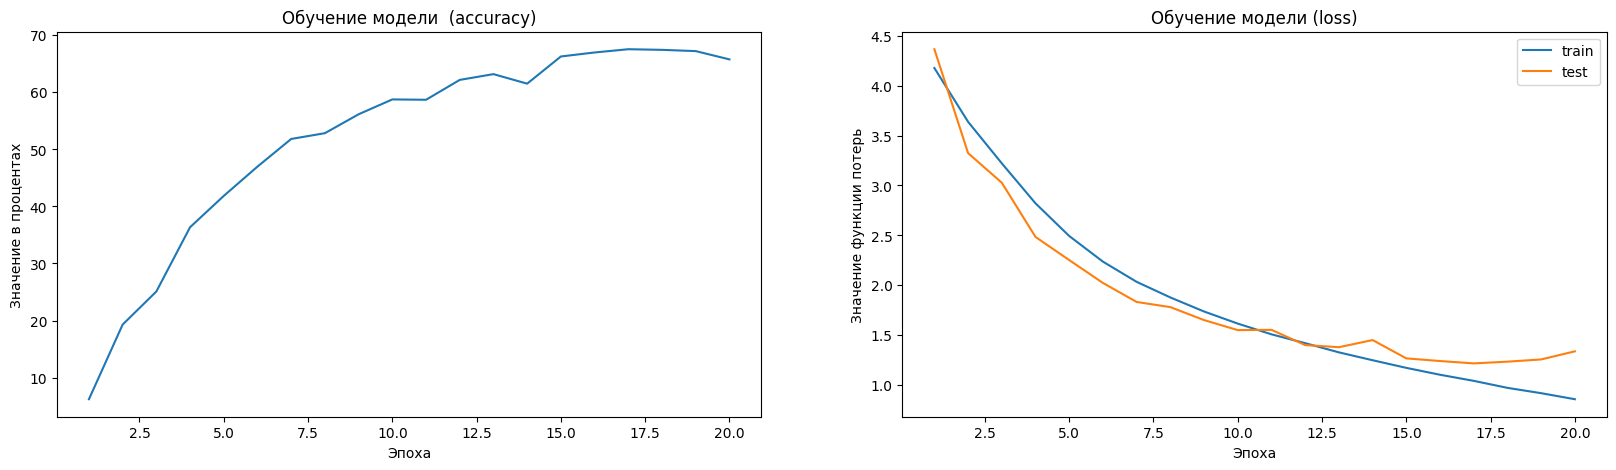

In [28]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(epoch_nums, accuracy)
plt.title('Обучение модели  (accuracy)')
plt.xlabel('Эпоха')
plt.ylabel('Значение в процентах')

plt.subplot(1, 2, 2)
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.title('Обучение модели (loss)')
plt.xlabel('Эпоха')
plt.ylabel('Значение функции потерь')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [23]:
print(f"EfficientNet-B2 accuracy: {round(test_loss[1] / 100, 2)}")
print(f"EfficientNet-B2 precision (weighted): {test_loss[2]}")
print(f"EfficientNet-B2 recall (weighted): {test_loss[3]}")
print(f"EfficientNet-B2 f1 (weighted): {test_loss[4]}")

EfficientNet-B2 accuracy: 0.66
EfficientNet-B2 precision (weighted): 0.68
EfficientNet-B2 recall (weighted): 0.66
EfficientNet-B2 f1 (weighted): 0.66


К сожалению, модели семейства EfficientNet с бóльшим количеством параметров (EfficientNet-B3, B4 ... B7) обучить не получится в силу ограниченных вычислительных способностей kaggle.

# **2.3 Сравнение моделей**

Модель EfficientNet-B1 на протяжении всего обучения показывала все более качественные результаты предсказаний, в то время как точность EfficientNet-B2 на последних 2-3 эпохах снизилась на 2 процента. В результате обучения на 20 эпохах наилучшую точность показывает модель **EfficientNet-B1**, она же и будет использована внутри **микросервиса**.

# **3. Анализ ошибок**

Посмотрим, на каких классах модель чаще всего ошибается.

In [24]:
torch.save(model.state_dict(), 'efficientnet_b2_20_epochs.pt')

In [26]:
from IPython.display import FileLink
FileLink(r'efficientnet_b2_20_epochs.pt')

/kaggle/working/efficientnet_b2_20_epochs.pt

# **3.1 Модель EfficientNet-B1**

In [75]:
model.eval()
incorrect_outputs = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        incorrect_outputs += target[target!=predicted].tolist()

Text(0.5, 0, 'Индекс класса')

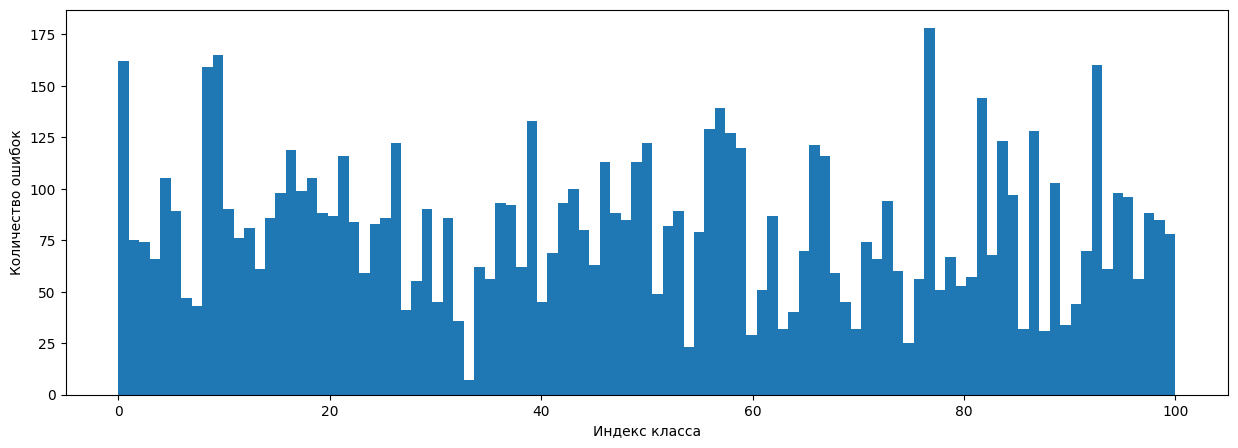

In [78]:
plt.figure(figsize=(15, 5))
res = plt.hist([incorrect_outputs], bins=101)
plt.ylabel('Количество ошибок')
plt.xlabel('Индекс класса')

Топ-5 классов, на которых модель EfficientNet-B2 ошибается **чаще** всего:

In [79]:
for i in np.argsort(res[0])[-5:][::-1]:
    print(id2label[i], int(res[0][i]))

pork_chop 178
breakfast_burrito 165
apple_pie 162
steak 160
bread_pudding 159


Топ-5 классов, на которых модель ошибается EfficientNet-B2 **реже** всего:

In [80]:
for i in np.argsort(res[0])[:5]:
    print(id2label[i], int(res[0][i]))

edamame 7
hot_and_sour_soup 23
pho 25
lobster_bisque 29
seaweed_salad 31


# **3.2 Модель EfficientNet-B2**

In [83]:
model.eval()
incorrect_outputs = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        incorrect_outputs += target[target!=predicted].tolist()

Text(0.5, 0, 'Индекс класса')

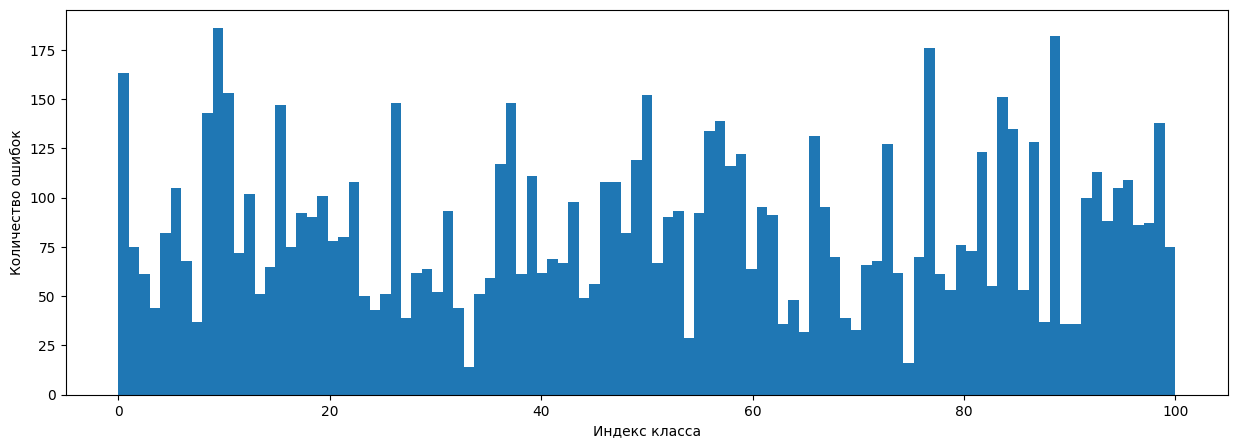

In [84]:
plt.figure(figsize=(15, 5))
res = plt.hist([incorrect_outputs], bins=101)
plt.ylabel('Количество ошибок')
plt.xlabel('Индекс класса')

Топ-5 классов, на которых модель EfficientNet-B2 ошибается **чаще** всего:

In [85]:
for i in np.argsort(res[0])[-5:][::-1]:
    print(id2label[i], int(res[0][i]))

breakfast_burrito 186
shrimp_and_grits 182
pork_chop 176
apple_pie 163
bruschetta 153


Топ-5 классов, на которых модель ошибается EfficientNet-B2 **реже** всего:

In [86]:
for i in np.argsort(res[0])[:5]:
    print(id2label[i], int(res[0][i]))

edamame 14
pho 16
hot_and_sour_soup 29
mussels 32
pad_thai 33


# **4. Примечание**
Таблица переводов из id в label

In [70]:
id2label

{0: 'apple_pie',
 1: 'baby_back_ribs',
 2: 'baklava',
 3: 'beef_carpaccio',
 4: 'beef_tartare',
 5: 'beet_salad',
 6: 'beignets',
 7: 'bibimbap',
 8: 'bread_pudding',
 9: 'breakfast_burrito',
 10: 'bruschetta',
 11: 'caesar_salad',
 12: 'cannoli',
 13: 'caprese_salad',
 14: 'carrot_cake',
 15: 'ceviche',
 16: 'cheese_plate',
 17: 'cheesecake',
 18: 'chicken_curry',
 19: 'chicken_quesadilla',
 20: 'chicken_wings',
 21: 'chocolate_cake',
 22: 'chocolate_mousse',
 23: 'churros',
 24: 'clam_chowder',
 25: 'club_sandwich',
 26: 'crab_cakes',
 27: 'creme_brulee',
 28: 'croque_madame',
 29: 'cup_cakes',
 30: 'deviled_eggs',
 31: 'donuts',
 32: 'dumplings',
 33: 'edamame',
 34: 'eggs_benedict',
 35: 'escargots',
 36: 'falafel',
 37: 'filet_mignon',
 38: 'fish_and_chips',
 39: 'foie_gras',
 40: 'french_fries',
 41: 'french_onion_soup',
 42: 'french_toast',
 43: 'fried_calamari',
 44: 'fried_rice',
 45: 'frozen_yogurt',
 46: 'garlic_bread',
 47: 'gnocchi',
 48: 'greek_salad',
 49: 'grilled_chees